<a href="https://colab.research.google.com/github/17092003vamsi/guner/blob/main/SVM_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training Accuracy: 1.0000
Testing Accuracy: 0.9572


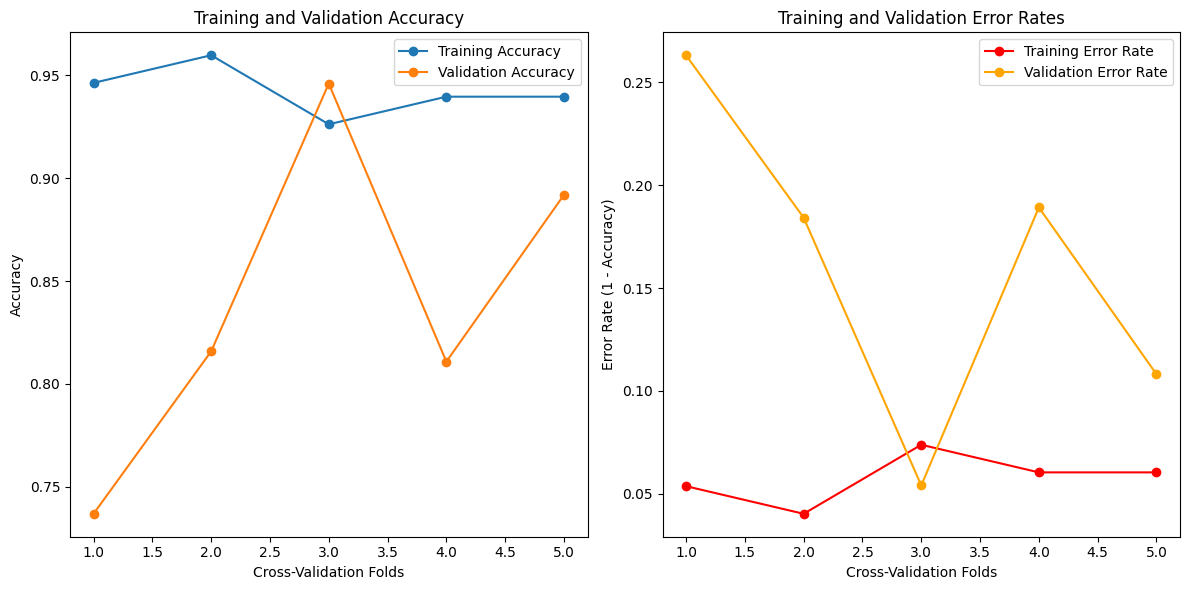

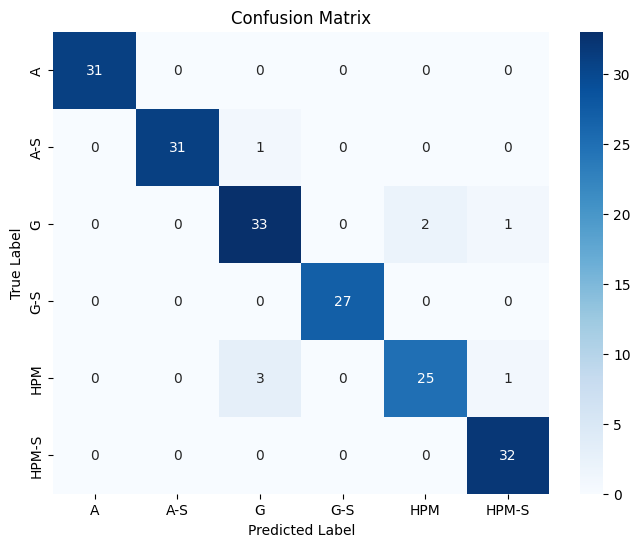

Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        31
         A-S       1.00      0.97      0.98        32
           G       0.89      0.92      0.90        36
         G-S       1.00      1.00      1.00        27
         HPM       0.93      0.86      0.89        29
       HPM-S       0.94      1.00      0.97        32

    accuracy                           0.96       187
   macro avg       0.96      0.96      0.96       187
weighted avg       0.96      0.96      0.96       187



  0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Load the data
data = pd.read_csv('/content/project 2 sap.csv')

# Encode categorical features
type_encoder = LabelEncoder()
data['Type'] = type_encoder.fit_transform(data['Type'])

label_encoder = LabelEncoder()
data['Lable'] = label_encoder.fit_transform(data['Lable'])

# Separate features and target
X = data.drop(columns=['Lable'])
y = data['Lable']

# Handle missing values in the dataset
imputer = SimpleImputer(strategy='mean')  # Replace NaNs with column mean
X = imputer.fit_transform(X)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and train the SVM model
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train)

# Make predictions
y_pred_train = svm_model.predict(X_train)
y_pred_test = svm_model.predict(X_test)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

# Cross-validation for training and validation accuracy and error rate
train_scores = cross_val_score(svm_model, X_train, y_train, cv=5)
val_scores = cross_val_score(svm_model, X_test, y_test, cv=5)

train_error_rates = 1 - train_scores
val_error_rates = 1 - val_scores
folds = np.arange(1, len(train_scores) + 1)

# Plot training and validation accuracy and error rates
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(folds, train_scores, label='Training Accuracy', marker='o')
plt.plot(folds, val_scores, label='Validation Accuracy', marker='o')
plt.xlabel('Cross-Validation Folds')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(folds, train_error_rates, label='Training Error Rate', marker='o', color='red')
plt.plot(folds, val_error_rates, label='Validation Error Rate', marker='o', color='orange')
plt.xlabel('Cross-Validation Folds')
plt.ylabel('Error Rate (1 - Accuracy)')
plt.legend()
plt.title('Training and Validation Error Rates')

plt.tight_layout()
plt.show()

# Plot confusion matrix for test set
conf_matrix = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("Classification Report:")
# Fix for mismatch in class labels
print(classification_report(y_test, y_pred_test, target_names=label_encoder.classes_[:len(np.unique(y_test))]))

# Initialize SHAP explainer for SVM with a subset of data
# Using only a sample of the training set to speed up SHAP calculation
X_train_sample = X_train[:200]  # Use the first 200 samples (or adjust to your preference)

explainer = shap.KernelExplainer(svm_model.predict_proba, shap.kmeans(X_train_sample, 10))

# Calculate SHAP values for training and test sets (with fewer samples)
shap_values_train = explainer.shap_values(X_train_sample)  # Use the sample for training set
shap_values_test = explainer.shap_values(X_test[:200])  # Use the first 200 samples of the test set

# SHAP summary plot for test set
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_test, X_test[:200], plot_type="bar", feature_names=data.drop(columns=['Lable']).columns)
plt.title("SHAP Feature Importance for Test Set")
plt.show()

# SHAP summary plot for training set
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_train, X_train_sample, plot_type="bar", feature_names=data.drop(columns=['Lable']).columns)
plt.title("SHAP Feature Importance for Training Set")
plt.show()
